In [1]:
import numpy as np
import tensorflow as tf
import pickle
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Embedding
from keras.layers import LSTM
import preproc
from importlib import reload
import train_utils

DATA_DIR = "data"

Using TensorFlow backend.


# Prepare training data

In [2]:
VOCAB_SIZE = 3000
data, labels = pickle.load(open(DATA_DIR + "/train_data.pyObj", "rb"))
labels = labels - 1
freq_vec = data["freq"]
stroke_vec = data["stroke"]

np.random.seed(125655)
rand_idx = np.random.permutation(range(len(labels)))
train_idx = rand_idx[:int(len(rand_idx) * 0.6)]
cv_idx = rand_idx[int(len(rand_idx) * 0.6):int(len(rand_idx) * 0.2)]
test_idx = rand_idx[int(len(rand_idx) * 0.8):]
text_mat = preproc.preproc_text_vec(data["text"], VOCAB_SIZE)

# Setup Model

In [9]:
# define input layers
input_text = Input(shape=(None, ), name="input_text")
input_freq = Input(shape=(4,), name="input_freq")
input_stroke = Input(shape=(3,), name="input_stroke")

# embedding layers for text
embed = Embedding(VOCAB_SIZE, 20)(input_text)
lstm = LSTM(30)(embed)

# dense for freq/stroke
input_fs = keras.layers.concatenate([input_freq, input_stroke])
dense1 = Dense(3, activation="sigmoid")(input_fs)    

# concatenate sequence layers and other two inputs
concat = keras.layers.concatenate([lstm, dense1])

# connect to outputs
dense2 = Dense(20, activation="sigmoid")(concat)
grade_out = Dense(6, activation="softmax")(dense2)

model = Model(inputs = [input_text, input_freq, input_stroke], 
            outputs = [grade_out])

model.compile(optimizer = 'rmsprop', 
            loss="categorical_crossentropy", 
            metrics = ["accuracy"])

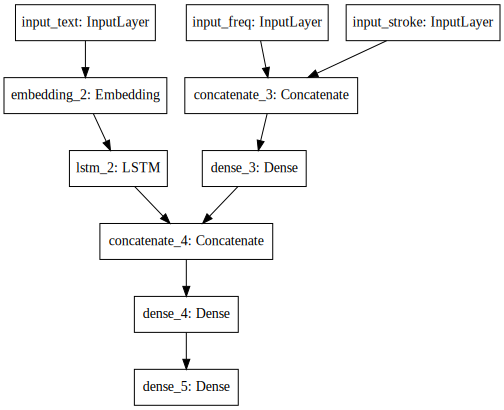

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Training

In [8]:
EPOCH = 10
cost_vec = []
acc_vec = []
print("Training data: %d samples" % len(train_idx))

for epoch_i in range(EPOCH):
    print(" --- Epoch {} --- ".format(epoch_i))
    counter = 0

    for sample_idx in train_idx:
        sample = text_mat[sample_idx]
        label = labels[sample_idx]
        freq = freq_vec[sample_idx]
        stroke = stroke_vec[sample_idx]
        freq = freq / np.sum(freq)
        stroke = stroke/np.sum(stroke)
        ret = model.train_on_batch(
                [np.array([sample]), np.array([freq]), np.array([stroke])], 
                keras.utils.to_categorical(label, 6))
        cost_vec.append(ret[0])
        acc_vec.append(ret[1])

        global_iter = epoch_i * len(train_idx) + counter        

        mv_cost = np.mean(cost_vec[-100:])
        mv_acc = np.mean(acc_vec[-100:])
        if (global_iter + 1) % 100 == 0:
            train_utils.write_log(tb_callback, global_iter, 
                    ["loss", "accuracy"], [mv_cost, mv_acc])

        if (global_iter + 1) % 500 == 0:                        
            print("validating model...")
            val_loss, val_acc = train_utils.test_model(
                model, test_idx, data, labels, VOCAB_SIZE)
            print("Validation: loss: {:f}, acc: {:.2f}".format(val_loss, val_acc))
            train_utils.write_log(tb_callback, global_iter, 
                    ["val_loss", "val_accuracy"], [val_loss, val_acc])    

        # if counter >= 3:
        #     break   
        print("[% 4d] cost: %s, accuracy: %.2f" % (counter, mv_cost, mv_acc))
        counter += 1

Training data: 784 samples
 --- Epoch 0 --- 
[   0] cost: 1.35231, accuracy: 1.00
[   1] cost: 1.37075, accuracy: 1.00
[   2] cost: 1.58928, accuracy: 0.67
 --- Epoch 1 --- 
[   0] cost: 1.48184, accuracy: 0.80
[   1] cost: 1.44392, accuracy: 0.83
[   2] cost: 1.51751, accuracy: 0.71
 --- Epoch 2 --- 
[   0] cost: 1.42903, accuracy: 0.78
[   1] cost: 1.37151, accuracy: 0.80
[   2] cost: 1.43588, accuracy: 0.70
 --- Epoch 3 --- 
[   0] cost: 1.20922, accuracy: 0.80
[   1] cost: 1.09501, accuracy: 0.80
[   2] cost: 1.19584, accuracy: 0.70
 --- Epoch 4 --- 
[   0] cost: 0.949924, accuracy: 0.80
[   1] cost: 0.852173, accuracy: 0.80
[   2] cost: 0.937655, accuracy: 0.70
 --- Epoch 5 --- 
[   0] cost: 0.690789, accuracy: 0.80
[   1] cost: 0.626508, accuracy: 0.80
[   2] cost: 0.772273, accuracy: 0.70
 --- Epoch 6 --- 
[   0] cost: 0.544295, accuracy: 0.80
[   1] cost: 0.506109, accuracy: 0.80
[   2] cost: 0.65539, accuracy: 0.70
 --- Epoch 7 --- 
[   0] cost: 0.458682, accuracy: 0.80
[   1]

In [14]:
np.array(freq_vec[sample_idx]).shape


(4,)

In [31]:
freq_vec[0].tolist()

[60, 1, 1, 0]